In [ ]:
# Clone the repo into Colab (only if not already done)
import os
if not os.path.exists("MITE-Su25-cellular-automata"):
    !git clone https://github.com/bleerian/MITE-Su25-cellular-automata.git
    %cd MITE-Su25-cellular-automata
else:
    %cd MITE-Su25-cellular-automata

# Add the package path to Python’s import path
import sys
sys.path.append('./game-of-life')


# **Section 1: Animating Conway's Game of Life using Python**

## This code is a complete code of Conway's Game of Life using Python with preloaded patterns from a file called Pattern_grid.py (if you are interested in understanding the inner workings), otherwise, you can run this and input a given pattern.

## Note, this takes a little bit to load, but wait for the code to finish running, then play the animation

In [ ]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import time
from Pattern_grid import (
    addGlider, addGosperGliderGun, addExploder,
    addQuadExploder, addNegativeSpaceship,
    randomGrid, update
)

from matplotlib import animation  # for smooth animation

def main():
    # Detect if run in notebook
    if 'ipykernel' in sys.modules:
        patterns_input = input("Choose one or more patterns (comma-separated: glider, gosper, exploder, quadexploder, negativespaceship, random): ").lower()
        patterns = [p.strip() for p in patterns_input.split(",") if p.strip() in ['glider', 'gosper', 'exploder', 'quadexploder', 'negativespaceship', 'random'] ]

        if not patterns:
            print("No valid patterns selected. Defaulting to random.")
            patterns = ['random']

        class Args:
            def __init__(self, N=100, interval=50, patterns='random'):
                self.N = N
                self.interval = interval
                self.patterns = patterns
        args = Args(patterns=patterns)
    else:
        parser = argparse.ArgumentParser(description="Runs Conway's Game of Life simulation.")
        parser.add_argument('--grid-size', dest='N', type=int, default=100,
                            help="Size of the NxN grid (default: 100).")
        parser.add_argument('--interval', type=int, default=50,
                            help="Animation update interval in milliseconds (default: 50).")
        parser.add_argument('--pattern', nargs='+', choices=['glider', 'gosper', 'exploder', 'quadexploder', 'negativespaceship', 'random'], default=['random'],
                            help="Pattern(s) to initialize: glider, gosper, exploder, quadexploder, negativespaceship, random.")
        args = parser.parse_args()

    N = args.N
    updateInterval = args.interval
    grid = np.zeros((N, N))

    for pattern in args.patterns:
        if pattern == 'glider':
            addGlider(1, 1, grid)
        elif pattern == 'gosper':
            if N < 50:
                print("Grid too small for Gosper Glider Gun, increasing size to 50.")
                N = 50
                grid = np.zeros((N, N))
            addGosperGliderGun(10, 10, grid)
        elif pattern == 'exploder':
            addExploder(N//2 - 2, N//2 - 2, grid)
        elif pattern == 'quadexploder':
            addQuadExploder(N//2, N//2, grid)
        elif pattern == 'negativespaceship':
            addNegativeSpaceship(N//2 - 5, N//2 - 10, grid)
        elif pattern == 'random':
            grid += randomGrid(N)

    frames = 200

    fig, ax = plt.subplots(figsize=(10, 10))
    img = ax.imshow(grid, interpolation='nearest', cmap='gray', vmin=0, vmax=255)
    ax.set_title("Conway's Game of Life")

    def animate(frame):
        update(frame, img, grid, N)
        return [img]

    anim = animation.FuncAnimation(fig, animate, frames=frames, interval=updateInterval, blit=True)
    display(HTML(anim.to_jshtml()))
    plt.close(fig)


if __name__ == '__main__':
    main()


# **Section 2: Understanding the Code**

In our code we have hte pattern of 'alive' cells represented by a list of *tuples*, in which their index coordinate is contained in *alive cells* and the name of the pattern is contained in name

```
@dataclass
class Pattern:
    name: str
    alive_cells: set[tuple[int, int]]
```

The next step is to implement how the grid will evlove with each iteration. This is done in the provided *grid.py* as the method *LifeGrid.evolve(pattern)*, which takes as input an instance of the *class Pattern* shown above.

Here we show what that code looks like:


```
import collections

ALIVE = "♥"
DEAD = "○"

class LifeGrid:
    def __init__(self, pattern):
        self.pattern = pattern  # instance of class Pattern

    def evolve(self):
        neighbors = (
            (-1, -1), (-1, 0), (-1, 1),
            (0, -1),           (0, 1),
            (1, -1),  (1, 0),  (1, 1),
        )
        num_neighbors = collections.defaultdict(int)
        for row, col in self.pattern.alive_cells:
            for drow, dcol in neighbors:
                num_neighbors[(row + drow, col + dcol)] += 1

        stay_alive = {
            cell for cell, num in num_neighbors.items() if num in {2, 3}
        } & self.pattern.alive_cells
        come_alive = {
            cell for cell, num in num_neighbors.items() if num == 3
        } - self.pattern.alive_cells

        self.pattern.alive_cells = stay_alive | come_alive

    def __str__(self):
        return (
            f"{self.pattern.name}:\n"
            f"Alive cells -> {sorted(self.pattern.alive_cells)}"
        )

    def as_string(self, bbox):
        start_row, start_col, end_row, end_col = bbox
        display = [self.pattern.name.center(2 * (end_col - start_col))]
        for row in range(start_row, end_row):
            display_row = [
                f" {ALIVE}" if (row, col) in self.pattern.alive_cells else f" {DEAD}"
                for col in range(start_col, end_col)
            ]
            display.append("".join(display_row))
        return "\n".join(display)
```



## Now to get a feel for how these two (Pattern and Grid) work together, we will run through some examples :


In [ ]:
# Here we import the patterns.py and grid.py modules into this notebook as libraries
import patterns
import grid as grid_module


# In the next step, we can load a pattern called "Blinker" and we can "see" how the game evolves with this starting pattern

In [ ]:
# Load the pattern
blinker = patterns.get_pattern("Blinker")

# Create a grid with it
grid = grid_module.LifeGrid(blinker)

# Print the initial state
print("Generation 1 -", grid)

# Evolve the grid
grid.evolve()

# Print the updated pattern
print("Generation 2 -", grid)  # same object; now updated

grid.evolve()

print("Generation 3 -", grid)

# Previously we visualized each generation as an array of numbers based on their coordinate position, but what if we want to visualize the actual positions of each "alive" and "dead" cell?

In [ ]:
# Instantiate the grid with the pattern
life = grid_module.LifeGrid(blinker)

# Show initial state
print(life)

life.evolve() #This evolves each step to the next generation)
print(life.as_string((0, 0, 5, 5))) #Sets the bounding box: (start_row, start_col, end_row, end_col)
life.evolve()
print(life.as_string((0, 0, 5, 5)))

#

Then to clean up the code, we can use something known as a "for loop"


```
for i in range(3):                        # sets the code to loop this snippet 3 times
    life.evolve()                         # on each loop, the code will run an evolve function
    print(f"\nGeneration {i+1}")          # Outputs which generation the grid is in
    print(life.as_string((0, 0, 5, 5)))   # Prints the grid to visualize
```



In [ ]:
# Instantiate the grid with the pattern
life = grid_module.LifeGrid(blinker)

# Show initial state
print(life)

# Evolve and print each state
for i in range(3):
    life.evolve()
    print(f"\nGeneration {i+1}")
    print(life.as_string((0, 0, 5, 5)))

# View as string grid
#print(life.as_string((0, 0, 7, 7)))

# Step through a few more iterations
for i in range(3):
    life.evolve()
    print(f"\nGeneration {i+4}")
    print(life.as_string((0, 0, 5, 5)))


## Here we see how the starting "blinker" pattern updates through 6 generations.
---------------------------------------------------------------------
## Now, if we want to visualize our string-based grid representation in a notebook (like Google Colab or Jupyter), we can use something like IPython.display to clear the cell output and redraw the grid each generation.

## The code below uses a function called notebook_view to simulate Conway’s Game of Life in a Colab-friendly way:

In [ ]:
import time
import IPython.display

def notebook_view(pattern, generations=10, bbox=(0, 0, 30, 30), delay=0.3):
    life = grid_module.LifeGrid(pattern)
    for i in range(generations):
        IPython.display.clear_output(wait=True)
        print(f"Generation {i+1}")
        print(life.as_string(bbox))
        time.sleep(delay)
        life.evolve()

# Try it with Glider Gun
glider_gun = patterns.get_pattern("Glider Gun")
notebook_view(glider_gun, generations=50, bbox=(0, 0, 30, 30), delay=0.1)


The available patterns you can also try with the above code snippet are:

*   Blinker
*   Toad
*   Beacon
*   Pulsar
*   Penta Decathlon
*   Glider
*   Glider Gun
*   Bunnies


# Section 3: Modifying the Code

## Here you can experiment with modifying the logic that defines which cells count as neighbors to change the rule of which cells survive or die

## Here you can define the neighborhood in any way you'd like. The original Conway's game of life uses a Moore's Neighborhood that is represented in python like:


```
moore_neighbors = [
    (-1, -1), (-1, 0), (-1, 1),
    ( 0, -1),          ( 0, 1),
    ( 1, -1), ( 1, 0), ( 1, 1)
]
```

## Here you can see that neighbors in all directions, including the diagonals are considered neighbors

## Some of the other neighborhoods as seen in the worksheet like Von Neumann would be represented like:


```
von_neumann_neighbors = [
  (-1,0), # top
  (0,-1), (0,1), #left/right
  (1,0),  # bottom
]
```

## What about the other neighborhoods? Or even a custom one? How do they change how some of the patterns evolve?

The available patterns include:


*   Blinker
*   Toad
*   Beacon
*   Pulsar
*   Penta Decathlon
*   Glider
*   Glider Gun
*   Bunnies



In [ ]:
import time
import IPython.display
import types
import collections

# Step 1: Define the neighborhood
custom_neighbors = [
    (-1, 0),  # top
    ( 0, -1), (0, 1),  # left/right
    ( 1, 0),  # bottom
]

# Step 2: Define the custom evolve function with injected neighbor set
def custom_evolve(self, custom_neighbors):
    num_neighbors = collections.defaultdict(int)
    for row, col in self.pattern.alive_cells:
        for drow, dcol in custom_neighbors:
            num_neighbors[(row + drow, col + dcol)] += 1

    stay_alive = {
        cell for cell, num in num_neighbors.items() if num in {2, 3}
    } & self.pattern.alive_cells
    come_alive = {
        cell for cell, num in num_neighbors.items() if num == 3
    } - self.pattern.alive_cells

    self.pattern.alive_cells = stay_alive | come_alive

# Step 3: Create the grid with a pattern and inject new custom evolve
gun = patterns.get_pattern("Glider Gun")
grid = grid_module.LifeGrid(gun)
grid.evolve = types.MethodType(lambda self: custom_evolve(self, custom_neighbors), grid)

# Step 4: Modified notebook_view to accept a preconstructed grid
def notebook_view_from_grid(grid, generations=50, bbox=(0, 0, 20, 20), delay=0.2):
    for i in range(generations):
        IPython.display.clear_output(wait=True)
        print(f"Generation {i+1}")
        print(grid.as_string(bbox))
        time.sleep(delay)
        grid.evolve()

# Step 5: Run the simulation
notebook_view_from_grid(grid, generations=50, bbox=(0, 0, 20, 20), delay=0.1)


# Bonus: Implement your own pattern

In [ ]:
from patterns import Pattern

# 📝 Change this set to make your own pattern!
my_cells = {
    (2, 3), (2, 4),
    (3, 3), (3, 4)
}

my_pattern = Pattern("My Pattern", my_cells)

# Visualize it
grid = grid_module.LifeGrid(my_pattern)
notebook_view(my_pattern, generations=20, bbox=(0, 0, 10, 10), delay=0.2)


In [ ]:
my_pattern_from_toml = patterns.get_pattern("Wow")
notebook_view(my_pattern_from_toml, generations=1, bbox=(0, 0, 10, 10), delay=0.1)

# Part 2: Spinodal Decomposition

### Now, let's take a look at an example application of cellular automata in a materials science application.

### Alloys are mixtures of components. For example, bronze is an alloy of copper and tin; the addition of tin increases the hardness and strength. Another well-known example is steel, which is an alloy of iron with a few percent of carbon. Other metals are also added to enhance materials properties suh as corrosion resistance (e.g, stainless steel). It is also possible to make alloys of non-metallic elements. An example is InGaN, an alloy of indium nitride (InN) and gallium nitride (GaN), used in some light-emitting diode (LED) applications.

### In materials science, alloys are often referened to as "solid solutions" because the components of the system are evenly mixed together- or at least that is what we hope for!

### It turns out that many solid solutions do not always stay homogeneously mixed at all temperatures or pressure. Instead, they often segregate into different phaes. In some cases below a critical temperature, the phases spontaneously separate into domains with complex microstructure through a process known as *spinodal decomposition*.

## So the question is: **How does this materials process relate with Conway's Game of Life?**

### Game of Life vs. Spinodal Decomposition

| **Feature**                    | **Game of Life**                                             | **Spinodal Decomposition**                                        |
|-------------------------------|--------------------------------------------------------------|-------------------------------------------------------------------|
| **Cell State**                | Binary: alive or dead                                        | Continuous: real-valued `η` representing concentration difference |
| **Grid Type**                 | 2D square grid                                               | 2D square grid                                                    |
| **Neighborhood**              | Moore (8 neighbors treated equally)                          | Moore, but distinguishes nearest (UDLR) and next-nearest (diagonal) |
| **Update Rules**              | Simple rule-based logic (2–3 neighbors survive)              | Physics-based PDE-inspired update using energy and diffusion      |


In [2]:
sys.path.append('./spinodal-decomposition')

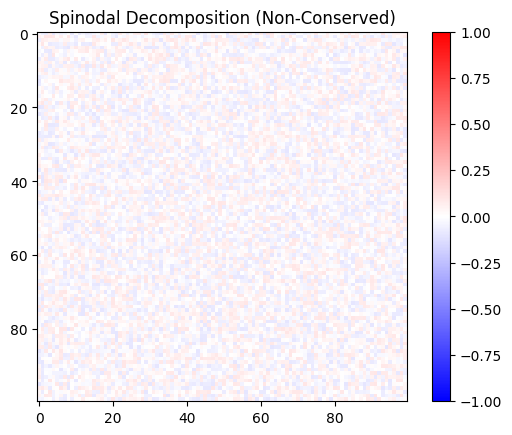

In [3]:
from spinodal_decomp import SpinodalNonConserved, SpinodalConserved

sim = SpinodalNonConserved(n=100, nstep=300, d=0.5, AA=1.3)
sim.animate()


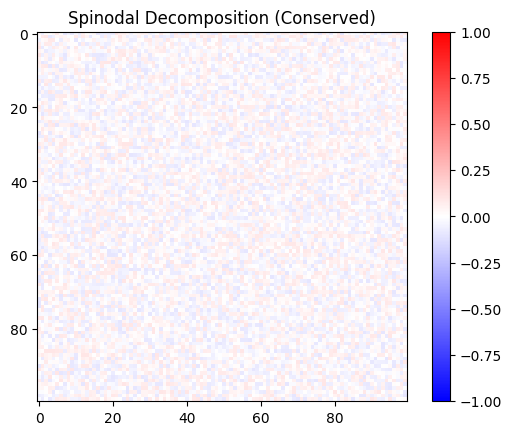

In [4]:
from spinodal_decomp import SpinodalConserved

sim = SpinodalConserved(n=100, nstep=300, d=0.5, AA=1.3)
sim.animate()
